## Install & Imports
Installs all necessary libraries for running model

In [3]:
import subprocess
import sys

# Define a function to install packages
def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check if torch is installed
try:
    import torch
except ImportError:
    print("PyTorch is not installed. Installing CPU version of PyTorch first...")
    pip_install("torch")
    pip_install("torchvision")
    pip_install("torchaudio")

# Check for GPU availability if torch is successfully imported
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Detected device: {device.upper()}")

    # Install appropriate version of PyTorch
    if device == "cuda":
        print("Installing PyTorch with GPU support...")
        pip_install("torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117")
    else:
        print("Installing PyTorch for CPU...")
        pip_install("torch")
        pip_install("torchvision")
        pip_install("torchaudio")
except Exception as e:
    print(f"Error while checking/installing PyTorch: {e}")
    device = "cpu"

# Install additional dependencies
print("Installing additional requirements...")
requirements = [
    "tqdm",
    "h5py",
    "numpy",
    "matplotlib",
    "seaborn",
    "plotly"
]

for package in requirements:
    pip_install(package)

print("All required packages have been installed.")


Detected device: CPU
Installing PyTorch for CPU...
Installing additional requirements...
All required packages have been installed.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from models.TacNet_model import MCTestTacNet
from scripts.data_loader import load_tactmat_data



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataloading & Preprocessing
Loads & Processes the Data to fit the model

In [5]:
from scripts.data_loader import load_tactmat_data

train_samples, test_samples, materials = load_tactmat_data('data/raw/tactmat.h5')

# Flatten data
train_samples = train_samples.reshape((36*80, 1000, 16))  # (2880, 1000, 16)
test_samples = test_samples.reshape((36*20, 1000, 16))  # (720, 1000, 16)

# Create labels
train_labels = np.repeat(np.arange(36), 80)  # (2880,)
test_labels = np.repeat(np.arange(36), 20)  # (720,)

# Shuffle
indices = torch.randperm(len(train_samples))
train_samples = train_samples[indices]
train_labels = train_labels[indices]

# One-hot encoding not needed for pytorch CrossEntropyLoss
train_samples = torch.tensor(train_samples.reshape(2880, 1, 1000, 16), dtype=torch.float32)
test_samples = torch.tensor(test_samples.reshape(720, 1, 1000, 16), dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

## Training Pipeline
Where the magic happens

In [6]:
# Instantiate Model
model = MCTestTacNet()
model.to(device)


# Training func
def train_model(model, train_samples, train_labels,val_samples,val_labels,  num_epochs=10, batch_size=32, learning_rate=0.001):
    train_dataset = TensorDataset(train_samples, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(val_samples, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)    
    
    train_samples = train_samples.to(device)
    train_labels = train_labels.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=170, gamma=0.1)
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) #forward pass
            loss = criterion(outputs, labels) #loss
            loss.backward() #backward pass
            optimizer.step() #update params
            running_loss += loss.item() #calc running loss

        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
        
        scheduler.step()
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    return model, val_loss
    
    print("Training complete!")

#run training
trained_model, val_error = train_model(model, train_samples, train_labels, test_samples, test_labels, num_epochs=200, batch_size=32, learning_rate=0.001)

# Save the model and validation error
torch.save(trained_model.state_dict(), "trained_model.pth")
with open("val_error.txt", "w") as f:
    f.write(str(val_error))

Epoch [1/200]: 100%|██████████| 90/90 [00:23<00:00,  3.77batch/s]


Epoch [1/200], Loss: 2.6790


Epoch [2/200]: 100%|██████████| 90/90 [00:24<00:00,  3.66batch/s]


Epoch [2/200], Loss: 1.6281


Epoch [3/200]: 100%|██████████| 90/90 [00:24<00:00,  3.64batch/s]


Epoch [3/200], Loss: 1.1287


Epoch [4/200]: 100%|██████████| 90/90 [00:24<00:00,  3.70batch/s]


Epoch [4/200], Loss: 0.8313


Epoch [5/200]: 100%|██████████| 90/90 [00:24<00:00,  3.70batch/s]


Epoch [5/200], Loss: 0.6316


Epoch [6/200]: 100%|██████████| 90/90 [00:24<00:00,  3.66batch/s]


Epoch [6/200], Loss: 0.4273


Epoch [7/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [7/200], Loss: 0.2722


Epoch [8/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [8/200], Loss: 0.2249


Epoch [9/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [9/200], Loss: 0.1578


Epoch [10/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [10/200], Loss: 0.0861


Epoch [11/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [11/200], Loss: 0.0556


Epoch [12/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [12/200], Loss: 0.0485


Epoch [13/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [13/200], Loss: 0.0334


Epoch [14/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [14/200], Loss: 0.0354


Epoch [15/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [15/200], Loss: 0.0405


Epoch [16/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [16/200], Loss: 0.0311


Epoch [17/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [17/200], Loss: 0.0320


Epoch [18/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [18/200], Loss: 0.0226


Epoch [19/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [19/200], Loss: 0.0373


Epoch [20/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [20/200], Loss: 0.0697


Epoch [21/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [21/200], Loss: 0.0484


Epoch [22/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [22/200], Loss: 0.0334


Epoch [23/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [23/200], Loss: 0.0449


Epoch [24/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [24/200], Loss: 0.0348


Epoch [25/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [25/200], Loss: 0.0332


Epoch [26/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [26/200], Loss: 0.0345


Epoch [27/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [27/200], Loss: 0.0329


Epoch [28/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [28/200], Loss: 0.0206


Epoch [29/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [29/200], Loss: 0.0206


Epoch [30/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [30/200], Loss: 0.0289


Epoch [31/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [31/200], Loss: 0.0186


Epoch [32/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [32/200], Loss: 0.0257


Epoch [33/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [33/200], Loss: 0.0608


Epoch [34/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [34/200], Loss: 0.0432


Epoch [35/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [35/200], Loss: 0.0249


Epoch [36/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [36/200], Loss: 0.0105


Epoch [37/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [37/200], Loss: 0.0110


Epoch [38/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [38/200], Loss: 0.0073


Epoch [39/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [39/200], Loss: 0.0170


Epoch [40/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [40/200], Loss: 0.0520


Epoch [41/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [41/200], Loss: 0.0460


Epoch [42/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [42/200], Loss: 0.0421


Epoch [43/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [43/200], Loss: 0.0553


Epoch [44/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [44/200], Loss: 0.0282


Epoch [45/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [45/200], Loss: 0.0208


Epoch [46/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [46/200], Loss: 0.0111


Epoch [47/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [47/200], Loss: 0.0058


Epoch [48/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [48/200], Loss: 0.0144


Epoch [49/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [49/200], Loss: 0.0220


Epoch [50/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [50/200], Loss: 0.0470


Epoch [51/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [51/200], Loss: 0.0571


Epoch [52/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [52/200], Loss: 0.0371


Epoch [53/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [53/200], Loss: 0.0161


Epoch [54/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [54/200], Loss: 0.0080


Epoch [55/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [55/200], Loss: 0.0033


Epoch [56/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [56/200], Loss: 0.0042


Epoch [57/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [57/200], Loss: 0.0024


Epoch [58/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [58/200], Loss: 0.0055


Epoch [59/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [59/200], Loss: 0.0022


Epoch [60/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [60/200], Loss: 0.0040


Epoch [61/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [61/200], Loss: 0.0081


Epoch [62/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [62/200], Loss: 0.0141


Epoch [63/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [63/200], Loss: 0.0270


Epoch [64/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [64/200], Loss: 0.0497


Epoch [65/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [65/200], Loss: 0.0391


Epoch [66/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [66/200], Loss: 0.0312


Epoch [67/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [67/200], Loss: 0.0288


Epoch [68/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [68/200], Loss: 0.0111


Epoch [69/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [69/200], Loss: 0.0043


Epoch [70/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [70/200], Loss: 0.0049


Epoch [71/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [71/200], Loss: 0.0098


Epoch [72/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [72/200], Loss: 0.0121


Epoch [73/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [73/200], Loss: 0.0025


Epoch [74/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [74/200], Loss: 0.0023


Epoch [75/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [75/200], Loss: 0.0010


Epoch [76/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [76/200], Loss: 0.0009


Epoch [77/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [77/200], Loss: 0.0007


Epoch [78/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [78/200], Loss: 0.0005


Epoch [79/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [79/200], Loss: 0.0006


Epoch [80/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [80/200], Loss: 0.0002


Epoch [81/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [81/200], Loss: 0.0004


Epoch [82/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [82/200], Loss: 0.0004


Epoch [83/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [83/200], Loss: 0.0005


Epoch [84/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [84/200], Loss: 0.0006


Epoch [85/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [85/200], Loss: 0.0002


Epoch [86/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [86/200], Loss: 0.0003


Epoch [87/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [87/200], Loss: 0.0002


Epoch [88/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [88/200], Loss: 0.0002


Epoch [89/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [89/200], Loss: 0.0002


Epoch [90/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [90/200], Loss: 0.0002


Epoch [91/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [91/200], Loss: 0.0002


Epoch [92/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [92/200], Loss: 0.0001


Epoch [93/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [93/200], Loss: 0.0001


Epoch [94/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [94/200], Loss: 0.0001


Epoch [95/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [95/200], Loss: 0.0002


Epoch [96/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [96/200], Loss: 0.0002


Epoch [97/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [97/200], Loss: 0.0002


Epoch [98/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [98/200], Loss: 0.0270


Epoch [99/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [99/200], Loss: 0.3994


Epoch [100/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [100/200], Loss: 0.1049


Epoch [101/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [101/200], Loss: 0.0362


Epoch [102/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [102/200], Loss: 0.0296


Epoch [103/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [103/200], Loss: 0.0100


Epoch [104/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [104/200], Loss: 0.0098


Epoch [105/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [105/200], Loss: 0.0052


Epoch [106/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [106/200], Loss: 0.0021


Epoch [107/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [107/200], Loss: 0.0018


Epoch [108/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [108/200], Loss: 0.0024


Epoch [109/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [109/200], Loss: 0.0033


Epoch [110/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [110/200], Loss: 0.0026


Epoch [111/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [111/200], Loss: 0.0016


Epoch [112/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [112/200], Loss: 0.0013


Epoch [113/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [113/200], Loss: 0.0040


Epoch [114/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [114/200], Loss: 0.0030


Epoch [115/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [115/200], Loss: 0.0043


Epoch [116/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [116/200], Loss: 0.0121


Epoch [117/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [117/200], Loss: 0.0137


Epoch [118/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [118/200], Loss: 0.0049


Epoch [119/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [119/200], Loss: 0.0045


Epoch [120/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [120/200], Loss: 0.0093


Epoch [121/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [121/200], Loss: 0.0028


Epoch [122/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [122/200], Loss: 0.0116


Epoch [123/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [123/200], Loss: 0.0250


Epoch [124/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [124/200], Loss: 0.0234


Epoch [125/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [125/200], Loss: 0.0282


Epoch [126/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [126/200], Loss: 0.0075


Epoch [127/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [127/200], Loss: 0.0023


Epoch [128/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [128/200], Loss: 0.0031


Epoch [129/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [129/200], Loss: 0.0015


Epoch [130/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [130/200], Loss: 0.0081


Epoch [131/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [131/200], Loss: 0.0094


Epoch [132/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [132/200], Loss: 0.0044


Epoch [133/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [133/200], Loss: 0.0071


Epoch [134/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [134/200], Loss: 0.0063


Epoch [135/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [135/200], Loss: 0.0118


Epoch [136/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [136/200], Loss: 0.0023


Epoch [137/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [137/200], Loss: 0.0011


Epoch [138/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [138/200], Loss: 0.0007


Epoch [139/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [139/200], Loss: 0.0005


Epoch [140/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [140/200], Loss: 0.0006


Epoch [141/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [141/200], Loss: 0.0004


Epoch [142/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [142/200], Loss: 0.0005


Epoch [143/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [143/200], Loss: 0.0003


Epoch [144/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [144/200], Loss: 0.0003


Epoch [145/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [145/200], Loss: 0.0003


Epoch [146/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [146/200], Loss: 0.0003


Epoch [147/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [147/200], Loss: 0.0003


Epoch [148/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [148/200], Loss: 0.0211


Epoch [149/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [149/200], Loss: 0.1799


Epoch [150/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [150/200], Loss: 0.0437


Epoch [151/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [151/200], Loss: 0.0209


Epoch [152/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [152/200], Loss: 0.0100


Epoch [153/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [153/200], Loss: 0.0025


Epoch [154/200]: 100%|██████████| 90/90 [00:24<00:00,  3.67batch/s]


Epoch [154/200], Loss: 0.0017


Epoch [155/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [155/200], Loss: 0.0020


Epoch [156/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [156/200], Loss: 0.0012


Epoch [157/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [157/200], Loss: 0.0013


Epoch [158/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [158/200], Loss: 0.0014


Epoch [159/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [159/200], Loss: 0.0064


Epoch [160/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [160/200], Loss: 0.0018


Epoch [161/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [161/200], Loss: 0.0017


Epoch [162/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [162/200], Loss: 0.0091


Epoch [163/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [163/200], Loss: 0.0087


Epoch [164/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [164/200], Loss: 0.0018


Epoch [165/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [165/200], Loss: 0.0006


Epoch [166/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [166/200], Loss: 0.0009


Epoch [167/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [167/200], Loss: 0.0024


Epoch [168/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [168/200], Loss: 0.0081


Epoch [169/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [169/200], Loss: 0.0068


Epoch [170/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [170/200], Loss: 0.0200


Epoch [171/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [171/200], Loss: 0.0063


Epoch [172/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [172/200], Loss: 0.0027


Epoch [173/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [173/200], Loss: 0.0027


Epoch [174/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [174/200], Loss: 0.0010


Epoch [175/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [175/200], Loss: 0.0034


Epoch [176/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [176/200], Loss: 0.0008


Epoch [177/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [177/200], Loss: 0.0010


Epoch [178/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [178/200], Loss: 0.0011


Epoch [179/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [179/200], Loss: 0.0011


Epoch [180/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [180/200], Loss: 0.0005


Epoch [181/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [181/200], Loss: 0.0006


Epoch [182/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [182/200], Loss: 0.0004


Epoch [183/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [183/200], Loss: 0.0016


Epoch [184/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [184/200], Loss: 0.0007


Epoch [185/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [185/200], Loss: 0.0007


Epoch [186/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [186/200], Loss: 0.0009


Epoch [187/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [187/200], Loss: 0.0006


Epoch [188/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [188/200], Loss: 0.0007


Epoch [189/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [189/200], Loss: 0.0003


Epoch [190/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [190/200], Loss: 0.0006


Epoch [191/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [191/200], Loss: 0.0002


Epoch [192/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [192/200], Loss: 0.0005


Epoch [193/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [193/200], Loss: 0.0009


Epoch [194/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [194/200], Loss: 0.0009


Epoch [195/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [195/200], Loss: 0.0004


Epoch [196/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [196/200], Loss: 0.0002


Epoch [197/200]: 100%|██████████| 90/90 [00:24<00:00,  3.69batch/s]


Epoch [197/200], Loss: 0.0002


Epoch [198/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [198/200], Loss: 0.0006


Epoch [199/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [199/200], Loss: 0.0005


Epoch [200/200]: 100%|██████████| 90/90 [00:24<00:00,  3.68batch/s]


Epoch [200/200], Loss: 0.0007
Validation Loss: 1.8025


In [7]:
# Save val_samples
torch.save(test_samples, "test_samples.pth")

# Save val_dataset
torch.save(test_labels, "test_labels.pth")


##  Monte Carlo Dropout for Uncertainty Estimation
Implementation of MCD for uncertainty estimation

In [3]:
import sys

# Load Test Data
test_samples = torch.load("test_samples.pth")
test_labels = torch.load("test_labels.pth")

# Define model class if not already defined (assuming MCTestTacNet class is defined as you've provided)
# Instantiate the Model
model = MCTestTacNet()
model.to(device)

# Load the Trained Model
model.load_state_dict(torch.load("trained_model.pth"))

# Function to enable dropout layers during test-time
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Function to get Monte Carlo predictions and uncertainty estimates
def get_monte_carlo_predictions(data_loader, forward_passes, model, n_classes, n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates through multiple forward passes """
    dropout_predictions = np.empty((0, n_samples, n_classes))
    softmax = nn.Softmax(dim=1)

    for i in range(forward_passes):
        predictions = np.empty((0, n_classes))
        model.eval()
        enable_dropout(model)

        for images, _ in data_loader:
            images = images.to(device)
            with torch.no_grad():
                outputs = model(images)
                outputs = softmax(outputs)
            predictions = np.vstack((predictions, outputs.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions, predictions[np.newaxis, :, :]))

    # Calculate mean across multiple MC Dropout forward passes
    mean = np.mean(dropout_predictions, axis=0)

    # Calculate variance across multiple MC Dropout forward passes
    variance = np.var(dropout_predictions, axis=0)

    epsilon = sys.float_info.min
    # Calculate entropy across multiple MC Dropout forward passes
    entropy = -np.sum(mean * np.log(mean + epsilon), axis=-1)

    # Calculate mutual information across multiple MC Dropout forward passes
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions * np.log(dropout_predictions + epsilon), axis=-1), axis=0)

    return mean, variance, entropy, mutual_info

# Prepare DataLoader for test data
batch_size = 32
test_dataset = TensorDataset(test_samples, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Parameters for Monte Carlo Dropout
forward_passes = 50  # Number of forward passes
n_classes = 36  # Number of classes
n_samples = len(test_samples)  # Number of test samples

# Get Monte Carlo Predictions and Uncertainty Estimates
mean, variance, entropy, mutual_info = get_monte_carlo_predictions(
    test_loader, forward_passes, model, n_classes, n_samples
)

# Print results (or further analyze)
print("Mean Predictions:", mean)
print("Variance Predictions:", variance)
print("Entropy Predictions:", entropy)
print("Mutual Information Predictions:", mutual_info)

/var/tmp/ipykernel_3443/2696586800.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_samples = torch.load("test_samples.pth")
/var/tmp/ipykernel_3443/2696586800.py:5:

Mean Predictions: [[6.80473421e-01 1.14727262e-04 3.02570870e-01 ... 5.03682740e-10
  2.52219922e-09 9.01246593e-11]
 [2.52232801e-03 8.62315810e-04 1.24997929e-04 ... 2.64668692e-07
  8.85428029e-05 2.57978251e-09]
 [3.76271113e-03 1.14351563e-01 2.23684648e-09 ... 2.12235853e-07
  2.87300001e-08 4.89568773e-04]
 ...
 [1.65184679e-12 1.73431799e-12 5.43425055e-12 ... 1.45116706e-11
  2.16536264e-07 9.99999750e-01]
 [5.38997289e-13 9.44117923e-15 1.42794755e-17 ... 1.22438288e-16
  1.43320191e-10 9.99999986e-01]
 [1.32480096e-07 3.29368357e-08 9.47932605e-08 ... 4.91884787e-10
  5.53426523e-04 9.99155827e-01]]
Variance Predictions: [[8.27029634e-02 1.49704272e-07 7.93277253e-02 ... 6.16011453e-19
  8.71131465e-17 2.16528148e-20]
 [1.77459991e-05 9.03000874e-06 2.42583681e-07 ... 3.07353147e-13
  2.02261698e-08 1.80343957e-17]
 [1.20879748e-04 2.41632469e-02 1.58394670e-17 ... 1.08702062e-13
  2.54277441e-15 7.83390284e-07]
 ...
 [2.95278855e-23 1.28590717e-23 3.22036289e-22 ... 8.99838

## Visualization of Uncertainty
Visualization of Model Uncertainty

/tmp/ipykernel_6968/3730970147.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_samples = torch.load("data/processed/test_samples.pth").numpy()
/tmp/ipykernel_6968/

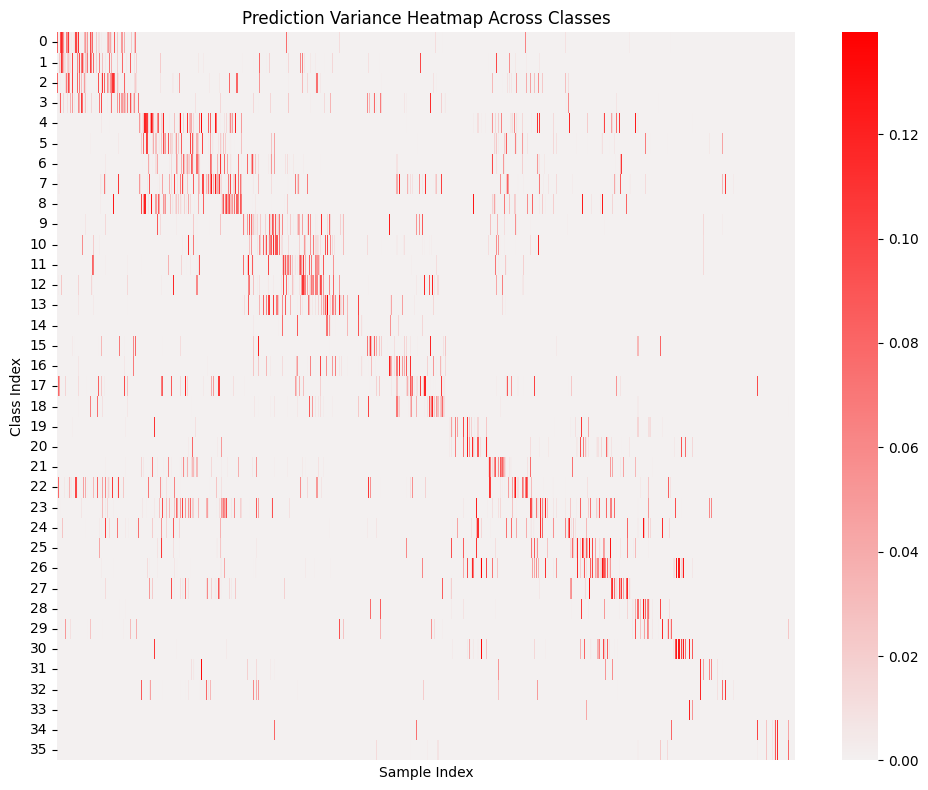

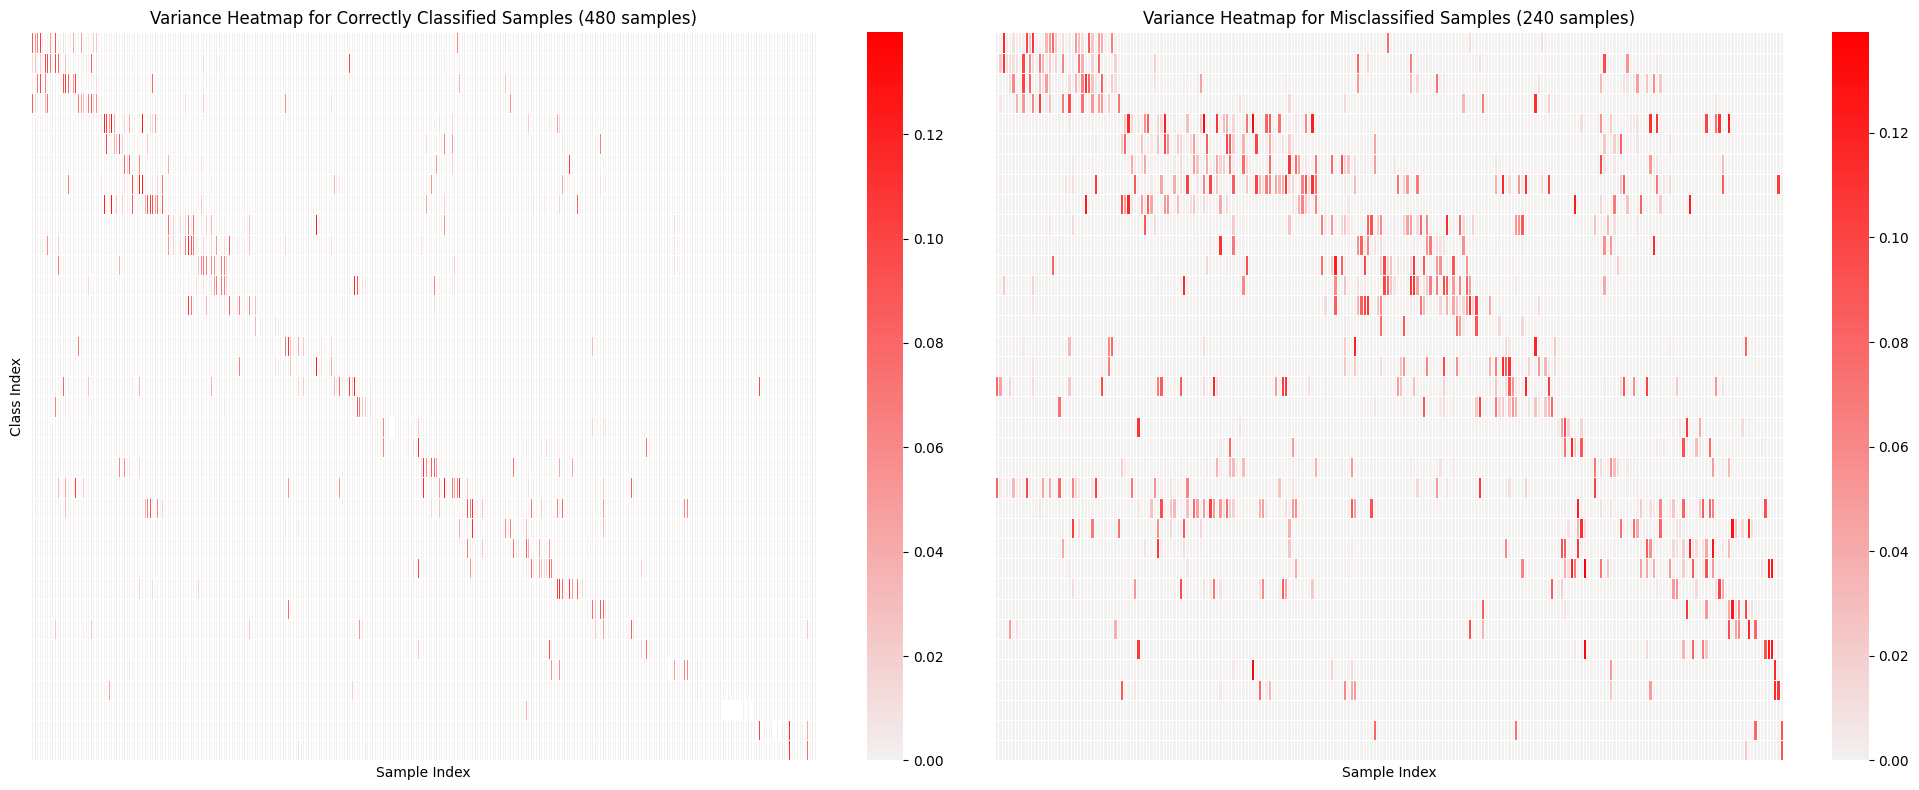

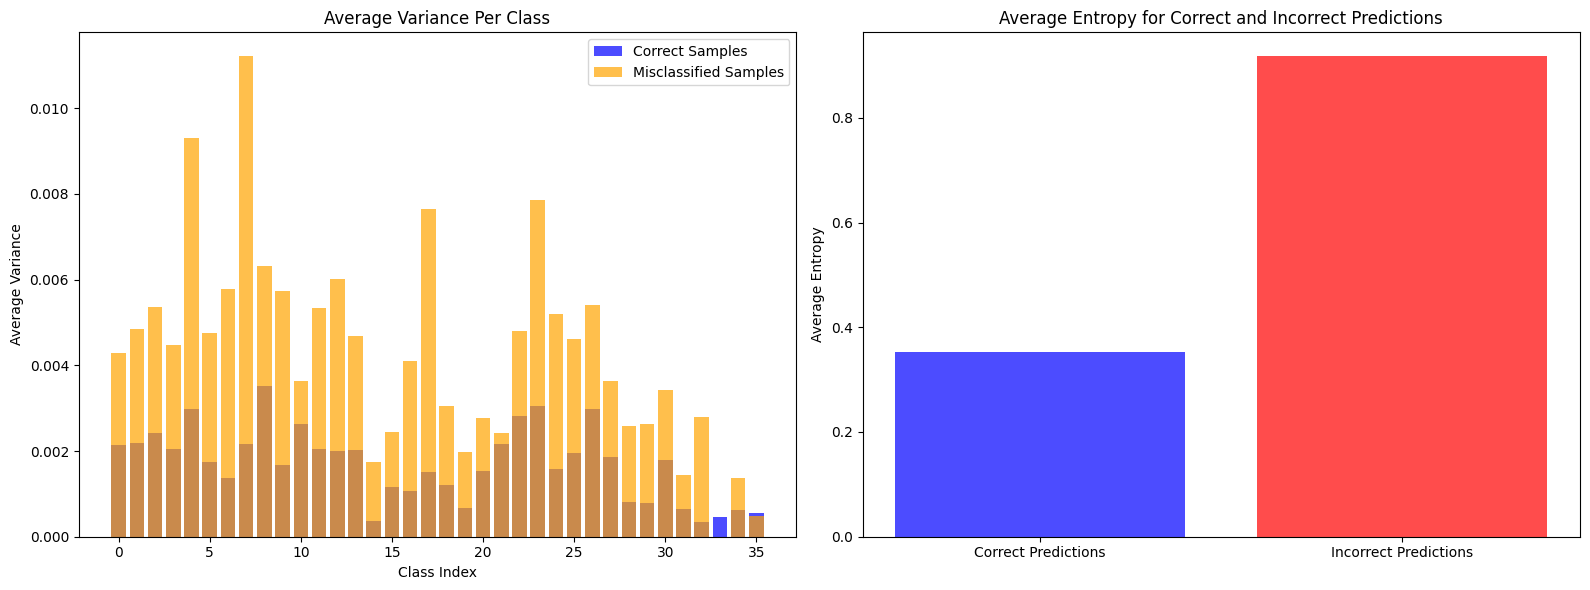

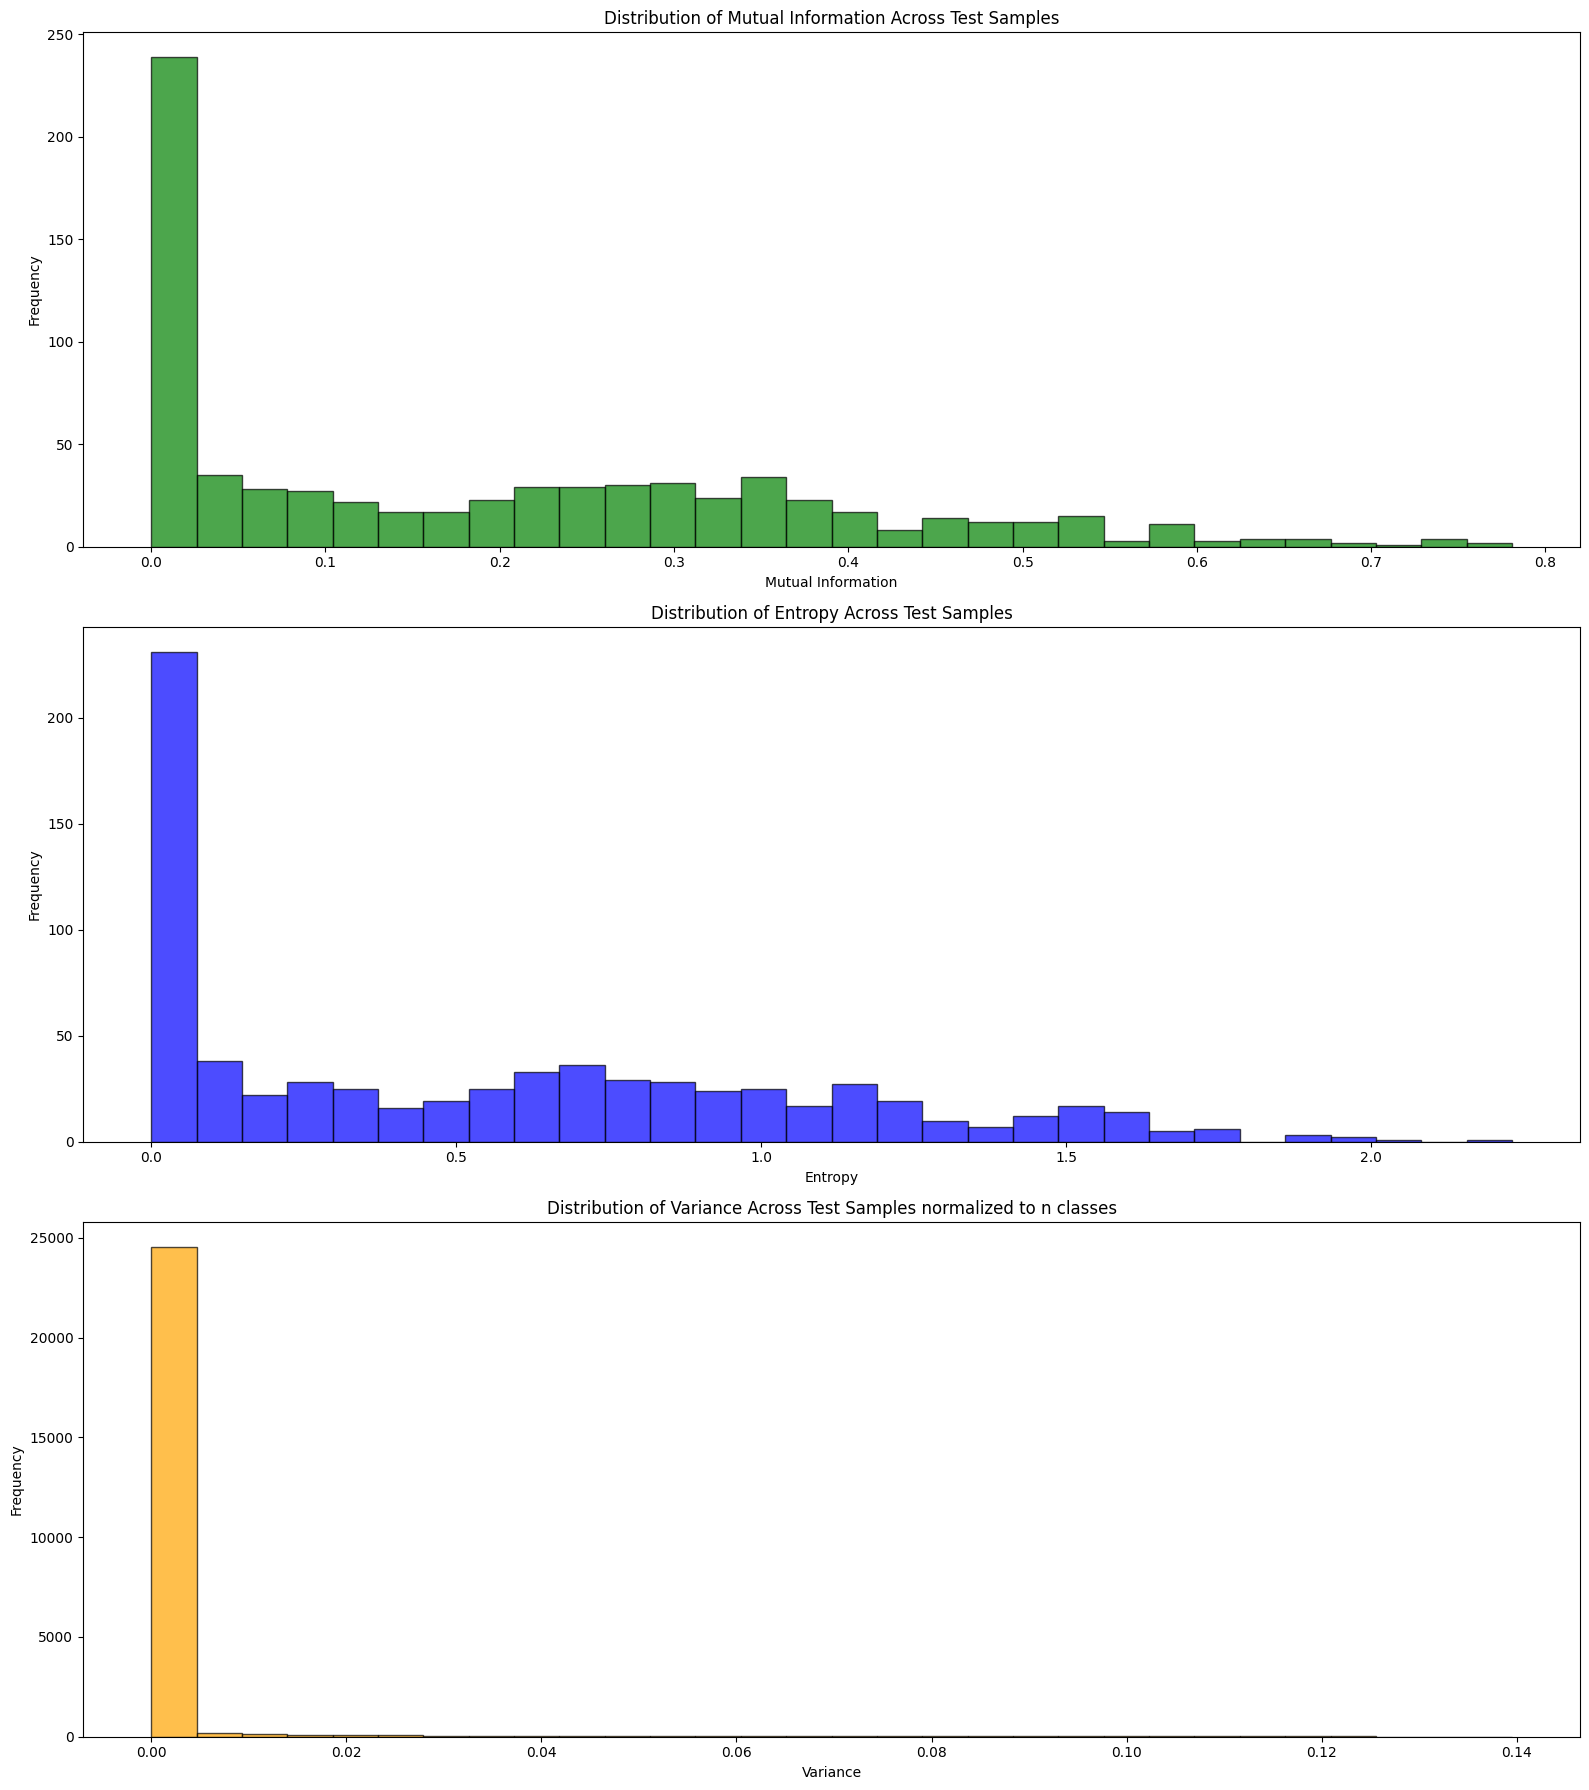

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Ensure the "visuals" directory exists
output_dir = "results/visuals"
os.makedirs(output_dir, exist_ok=True)

# Calculate predicted class from the mean logits
predictions = np.argmax(mean, axis=1)  # Predicted class indices based on maximum mean logit

# Identify correct and misclassified samples
correct_predictions = (predictions == test_labels)  # Boolean array for correct predictions
misclassified_predictions = ~correct_predictions   # Boolean array for misclassified predictions

# Extract variances for correct and misclassified predictions
correct_variance = variance[correct_predictions, :]  # Variance for correctly classified samples
misclassified_variance = variance[misclassified_predictions, :]  # Variance for misclassified samples



mean = np.load("data/predictions/mean_predictions.npy")
variance = np.load("data/predictions/variance_predictions.npy")
entropy = np.load("data/predictions/entropy_predictions.npy")
mutual_info = np.load("data/predictions/mutual_info_predictions.npy")
test_samples = torch.load("data/processed/test_samples.pth").numpy()
test_labels = torch.load("data/processed/test_labels.pth").numpy()

# plot doesnt make sense bc no variance when class = 0
plt.figure(figsize=(10, 8))
sns.light_palette("red", as_cmap=True)
sns.heatmap(variance.T, cmap=cmap, cbar=True, xticklabels=False, yticklabels=True) 
plt.xlabel("Sample Index")
plt.ylabel("Class Index")
plt.title("Prediction Variance Heatmap Across Classes")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "variance_heatmap_all_classes.png"))
plt.show()

# Create masks for zero variance
correct_mask = (correct_variance == 0)
misclassified_mask = (misclassified_variance == 0)

# Count the number of samples
num_correct_samples = correct_variance.shape[0]
num_misclassified_samples = misclassified_variance.shape[0]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Define colormap
cmap = sns.light_palette("red", as_cmap=True)  # Red-based colormap starting with white

# Heatmap for correctly classified samples
sns.heatmap(correct_variance.T, cmap=cmap, cbar=True, ax=axes[0], xticklabels=False, yticklabels=True,
            mask=correct_mask.T, linewidths=0.5, linecolor='white', vmin=0, vmax=np.max(correct_variance))
axes[0].set_title(f"Variance Heatmap for Correctly Classified Samples ({num_correct_samples} samples)")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Class Index")

# Heatmap for misclassified samples
sns.heatmap(misclassified_variance.T, cmap=cmap, cbar=True, ax=axes[1], xticklabels=False, yticklabels=False,
            mask=misclassified_mask.T, linewidths=0.5, linecolor='white', vmin=0, vmax=np.max(misclassified_variance))
axes[1].set_title(f"Variance Heatmap for Misclassified Samples ({num_misclassified_samples} samples)")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "variance_heatmap_correct_vs_misclassified.png"))
plt.show()

# Average variance per class
avg_variance_correct = np.mean(correct_variance, axis=0)
avg_variance_incorrect = np.mean(misclassified_variance, axis=0)

# Average entropy for correct and incorrect predictions
correct_entropy = entropy[correct_predictions]
incorrect_entropy = entropy[~correct_predictions]
categories = ['Correct Predictions', 'Incorrect Predictions']
avg_entropies = [np.mean(correct_entropy), np.mean(incorrect_entropy)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Average Variance Per Class
axes[0].bar(range(len(avg_variance_correct)), avg_variance_correct, label="Correct Samples", alpha=0.7, color='blue')
axes[0].bar(range(len(avg_variance_incorrect)), avg_variance_incorrect, label="Misclassified Samples", alpha=0.7, color='orange')
axes[0].set_xlabel("Class Index")
axes[0].set_ylabel("Average Variance")
axes[0].legend()
axes[0].set_title("Average Variance Per Class")

# Plot 2: Average Entropy for Correct and Incorrect Predictions
axes[1].bar(categories, avg_entropies, color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel("Average Entropy")
axes[1].set_title("Average Entropy for Correct and Incorrect Predictions")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "variance_entropy_bar_plots.png"))
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(16, 18))  # 3 rows, 1 column, stacked vertically

# Plot 1: Mutual Information Histogram
axes[0].hist(mutual_info, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Mutual Information")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Mutual Information Across Test Samples")

# Plot 2: Entropy Histogram
axes[1].hist(entropy, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Entropy")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Entropy Across Test Samples")

# Plot 3: Variance Histogram
axes[2].hist(variance.flatten(), bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Variance")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Variance Across Test Samples normalized to n classes")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "histograms_mutual_info_entropy_variance.png"))
plt.show()



